In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.basemap import Basemap
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.patches as patches
import math
import requests

In [2]:
def leer_matriz(nombre_archivo):
    matriz = []
    with open(nombre_archivo, 'r') as archivo:
        archivo.readline()
        archivo.readline()
        for linea in archivo:
            fila = [float(valor) for valor in linea.strip().split()]
            matriz.append(fila)
    return np.array(matriz)

In [3]:
nomenclatura = pd.read_csv('mibici/nomenclatura_2024_07.csv', encoding='latin1')

In [4]:
datos_ubicacion = nomenclatura[['id', 'latitude', 'longitude']]

In [5]:
ubicaciones = {row['id']: [row['latitude'], row['longitude']] for _, row in datos_ubicacion.iterrows()}

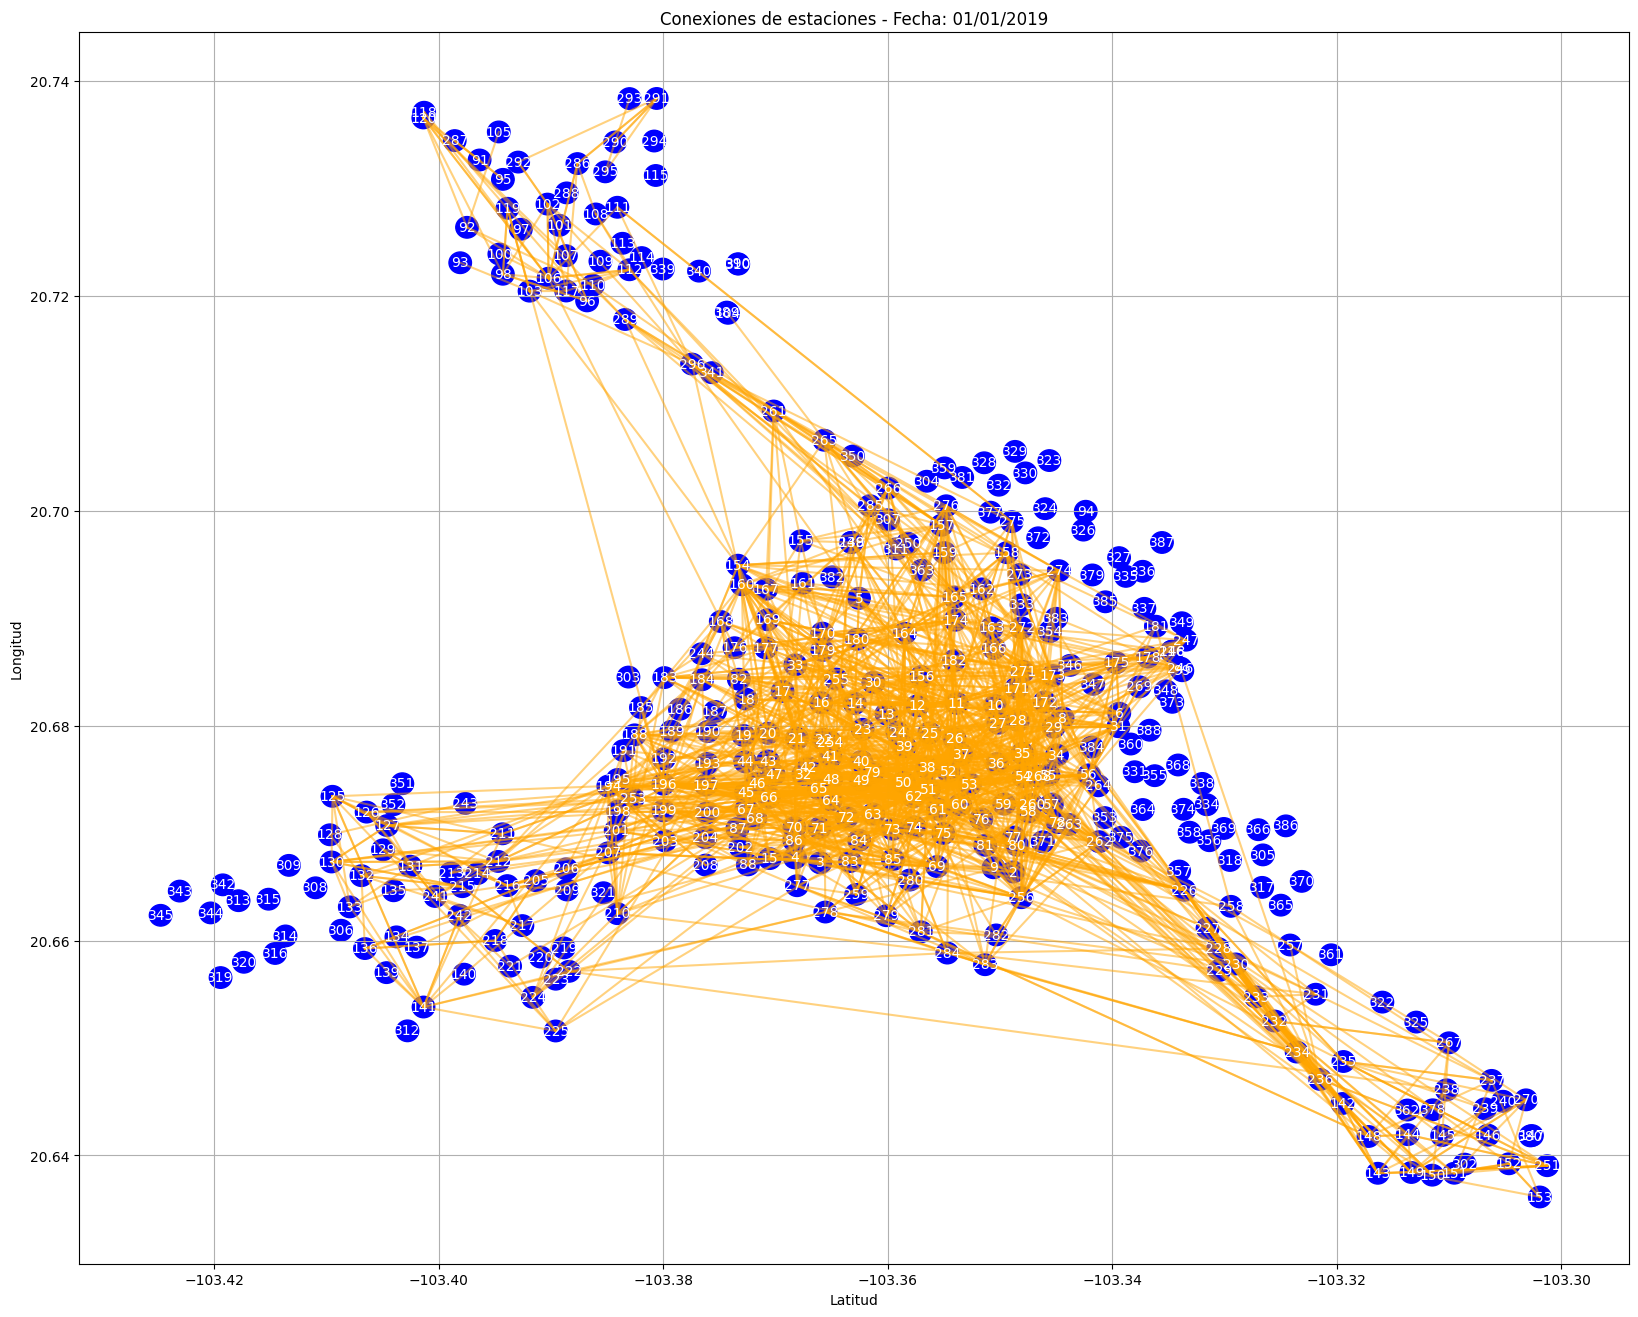

In [26]:
years = [2019]#, 2020, 2021, 2022, 2023, 2024]
# Lista para almacenar las matrices y las fechas correspondientes
matrices = []
dates = []
estaciones = []

# Iterar sobre cada año
for year in years:
    start_date = datetime(year, 1, 1)
    end_date = datetime(year, 1, 1)

    # Incremento de un día
    delta = timedelta(days=1)
    current_date = start_date

    estacion = leer_matriz(f'Adj_mibici/matrices_estaciones/estaciones_{year}.txt')
    dict_estaciones = {i: estacion[i][0] for i in range(len(estacion))}
    estaciones.append(dict_estaciones)

    while current_date <= end_date:
        date_str = current_date.strftime('%d_%m_%Y')
        filename = f'Adj_mibici/matrices_{year}/{date_str}.txt'

        if os.path.exists(filename):
            matrix = leer_matriz(filename)
            matrices.append(matrix)
            dates.append(current_date)
        else:
            print(f"El archivo {filename} no existe.")
        current_date += delta

if not matrices:
    raise ValueError("No se encontraron matrices para generar la animación.")

# Crear la figura y definir los límites del plano (ajusta según las coordenadas de tus estaciones)
fig, ax = plt.subplots(figsize=(20, 16))
ax.set_xlim(min([lon for _, (_, lon) in ubicaciones.items()]) - 0.01, max([lon for _, (_, lon) in ubicaciones.items()]) + 0.01)
ax.set_ylim(min([lat for _, (lat, _) in ubicaciones.items()]) - 0.01, max([lat for _, (lat, _) in ubicaciones.items()]) + 0.01)

# Función para actualizar el gráfico en cada frame
def update(frame):
    ax.clear()
    
    # Establecer el título con la fecha correspondiente
    ax.set_title(f"Conexiones de estaciones - Fecha: {dates[frame].strftime('%d/%m/%Y')}")
    year = dates[frame].year

    # Recorrer la matriz de adyacencia del día para dibujar las conexiones
    matrix = matrices[frame]
    estacion = estaciones[year - 2019]

    # Obtener los índices donde existe una conexión (valor mayor a 0 en la matriz)
    x, y = np.where(matrix > 0)

    for k in range(len(x)):
        # Obtener las coordenadas de inicio y fin de la conexión
        estacion_origen = estacion[x[k]]  # Estación de origen
        estacion_destino = estacion[y[k]]  # Estación de destino

        # Coordenadas (latitud, longitud) de las estaciones origen y destino
        p1 = ubicaciones[estacion_origen]
        p2 = ubicaciones[estacion_destino]

        # Graficar la línea que conecta las estaciones
        ax.plot([p1[1], p2[1]], [p1[0], p2[0]], color='orange', alpha=0.5)

    # Configurar la grilla y los ejes
    ax.grid()
    ax.set_xlabel('Latitud')
    ax.set_ylabel('Longitud')
    
    # Recorrer las ubicaciones para dibujar cada estación como un círculo
    for station_id, (lat, lon) in ubicaciones.items():
        # Dibujar la estación como un círculo
        circle = patches.Circle((lon, lat), 0.001, color='blue', fill=True)
        ax.add_patch(circle)
        # Añadir el ID de la estación dentro del círculo
        ax.text(lon, lat, str(int(station_id)), color='white', ha='center', va='center')

    return ax


# Crear la animación
ani = FuncAnimation(fig, update, frames=len(matrices), interval=150)

# Guardar la animación como un archivo .mp4
ani.save("conexiones_ecobici_plano_prueba.mp4", writer="ffmpeg", codec='mpeg4')

# Mostrar el gráfico en tiempo real (opcional)
plt.show()

#requests.post("https://ntfy.sh/Compu_CIMAT", data="Termino la simulación de prueba".encode(encoding='utf-8'))